In [405]:
import copy
from datetime import date, timedelta, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
import csv
from sklearn import tree
from itertools import *
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score, roc_auc_score
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import savgol_filter, argrelextrema
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

### Loading data

In [406]:
df_train = pd.read_csv('train.csv').set_index('PassengerId')
df_test = pd.read_csv('test.csv').set_index('PassengerId')
df_train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [407]:
df_train['title'] = df_train.Name.str.extract('([A-Za-z]+)\.')
df_train['title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)
df_train.groupby('title').Age.describe()

,count,mean,std,min,25%,50%,75%,max
title,,,,,,,,
Master,36.0,4.574167,3.619872,0.42,1.000,3.5,8.0,12.0
Miss,150.0,21.860000,12.828485,0.75,14.625,21.5,30.0,63.0
Mr,409.0,32.739609,12.875632,11.00,23.000,30.0,40.0,80.0
Mrs,110.0,35.981818,11.390469,14.00,28.000,35.0,44.0,63.0
Other,9.0,45.888889,12.604012,27.00,38.000,51.0,56.0,60.0


In [408]:
df_train.loc[(df_train.Age.isnull())&(df_train.title=='Mr'),'Age']=33
df_train.loc[(df_train.Age.isnull())&(df_train.title=='Mrs'),'Age']=36
df_train.loc[(df_train.Age.isnull())&(df_train.title=='Master'),'Age']=5
df_train.loc[(df_train.Age.isnull())&(df_train.title=='Miss'),'Age']=22
df_train.loc[(df_train.Age.isnull())&(df_train.title=='Other'),'Age']=46

In [409]:
df_test['title'] = df_test.Name.str.extract('([A-Za-z]+)\.')
df_test['title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mrs'],inplace=True)
df_test.groupby('title').Age.describe()

,count,mean,std,min,25%,50%,75%,max
title,,,,,,,,
Master,17.0,7.406471,4.672470,0.33,5.00,7.00,11.50,14.5
Miss,64.0,21.774844,10.457716,0.17,17.75,22.00,29.25,45.0
Mr,184.0,32.114130,11.873560,14.00,23.00,28.75,40.00,67.0
Mrs,63.0,38.904762,14.912340,16.00,26.00,37.00,49.00,76.0
Other,4.0,42.750000,9.810708,30.00,38.25,44.00,48.50,53.0


In [410]:
df_test.loc[(df_test.Age.isnull())&(df_test.title=='Mr'),'Age']=32
df_test.loc[(df_test.Age.isnull())&(df_test.title=='Mrs'),'Age']=39
df_test.loc[(df_test.Age.isnull())&(df_test.title=='Master'),'Age']=7
df_test.loc[(df_test.Age.isnull())&(df_test.title=='Miss'),'Age']=22
df_test.loc[(df_test.Age.isnull())&(df_test.title=='Other'),'Age']=43

In [411]:
# df_train[np.isnan(df_train.Age)]

In [604]:
from sklearn.preprocessing import RobustScaler

X_train = df_train.dropna(subset=['Age']).drop(['Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
X_train.Sex[X_train.Sex == 'male'] = False
X_train.Sex[X_train.Sex == 'female'] = True

X_train.Sex = pd.to_numeric(X_train.Sex)

X_train.Fare = np.log1p(X_train.Fare)
X_test.Fare = np.log1p(X_test.Fare)

y_train = df_train.dropna(subset=['Age']).Survived

X_test = df_test.drop(['Name', 'Ticket', 'Cabin'], axis=1)
X_test.Sex[X_test.Sex == 'male'] = False
X_test.Sex[X_test.Sex == 'female'] = True

X_test.Sex = pd.to_numeric(X_test.Sex)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    bool   
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  889 non-null    object 
 7   title     891 non-null    object 
dtypes: bool(1), float64(2), int64(3), object(2)
memory usage: 56.6+ KB


In [605]:
X_train['Family'] = X_train.SibSp + X_train.Parch
X_test['Family'] = X_test.SibSp + X_test.Parch
X_train = X_train.drop(['SibSp', 'Parch'], axis=1)
X_test = X_test.drop(['SibSp', 'Parch'], axis=1)


In [606]:
set(X_train.title)

{'Master', 'Miss', 'Mr', 'Mrs', 'Other'}

In [607]:
df_train.groupby('title').Survived.sum()

title
Master     23
Miss      131
Mr         86
Mrs       101
Other       1
Name: Survived, dtype: int64

In [608]:
X_train.title[X_train.title == 'Master'] = 2
X_train.title[X_train.title == 'Miss'] = 5
X_train.title[X_train.title == 'Mr'] = 3
X_train.title[X_train.title == 'Mrs'] = 4
X_train.title[X_train.title == 'Other'] = 1

X_test.title[X_test.title == 'Master'] = 2
X_test.title[X_test.title == 'Miss'] = 5
X_test.title[X_test.title == 'Mr'] = 3
X_test.title[X_test.title == 'Mrs'] = 4
X_test.title[X_test.title == 'Other'] = 1

X_train.title = pd.to_numeric(X_train.title)
X_test.title = pd.to_numeric(X_test.title)


In [609]:
X_train.Embarked[X_train.Embarked.isna()] = 0
X_train.Embarked[X_train.Embarked == 'C'] = 2
X_train.Embarked[X_train.Embarked == 'Q'] = 1
X_train.Embarked[X_train.Embarked == 'S'] = 3

X_test.Embarked[X_test.Embarked.isna()] = 0
X_test.Embarked[X_test.Embarked == 'C'] = 2
X_test.Embarked[X_test.Embarked == 'Q'] = 1
X_test.Embarked[X_test.Embarked == 'S'] = 3

X_train.Embarked = pd.to_numeric(X_train.Embarked)
X_test.Embarked = pd.to_numeric(X_test.Embarked)


(array([ 58.,  46., 213., 169., 255.,  70.,  45.,  24.,   9.,   2.]),
 array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
        64.084, 72.042, 80.   ]),
 <a list of 10 Patch objects>)

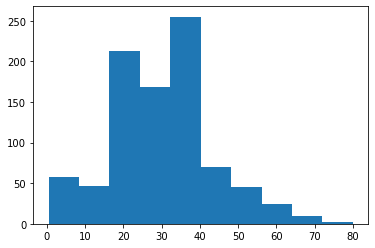

In [610]:
plt.hist(X_train.Age)

In [519]:
X_train['Survived'] = y_train

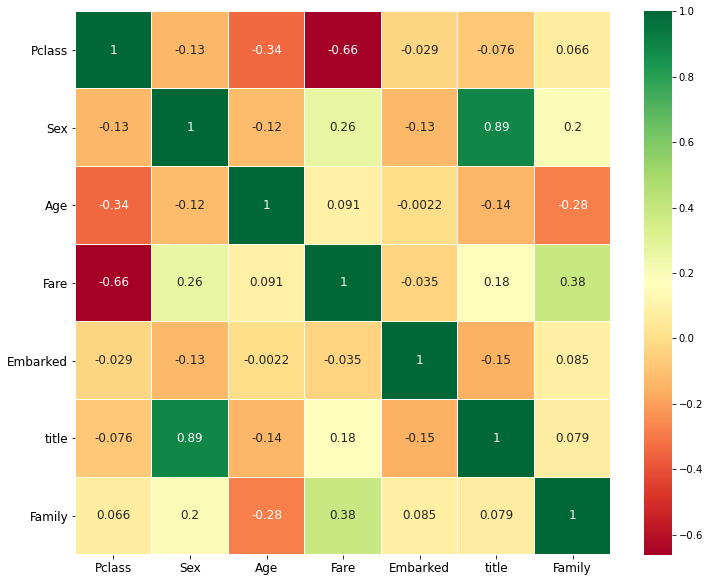

In [527]:
import seaborn as sns
sns.heatmap(X_train.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':12})
fig=plt.gcf()
fig.set_size_inches(12,10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [8]:
start_time = time.time()
for i in range(10000):
    j = i**i*np.power(i, 2)
print("--- %s seconds ---" % (time.time() - start_time))

<ipython-input-8-71fbfff54a40>:3: RuntimeWarning: overflow encountered in int_scalars
  j = i**i*np.power(i, 2)


--- 4.6469807624816895 seconds ---


In [4]:
import time
import numpy as np

In [613]:
X_test.isna().sum()

Pclass      0
Sex         0
Age         0
Fare        1
Embarked    0
title       0
Family      0
dtype: int64

In [615]:
X_test.Fare[X_test.Fare.isna()] = 0

In [529]:
X_train1, X_validation, y_train1, y_validation = train_test_split(
    X_train, y_train, test_size=0.33, random_state=0)

In [558]:
clf = DecisionTreeClassifier(random_state=0, max_depth=5)
clf.fit(X_train1, y_train1)
clf.predict(X_validation)
clf.score(X_validation, y_validation), clf.score(X_train1, y_train1)

(0.8067796610169492, 0.8573825503355704)

In [564]:
clf = RandomForestClassifier(random_state=None, n_estimators=100, max_depth=5)
clf.fit(X_train1, y_train1)
clf.predict(X_validation)
clf.score(X_validation, y_validation), clf.score(X_train1, y_train1)

(0.823728813559322, 0.8557046979865772)

In [555]:
clf = xgb.XGBClassifier(random_state=0, max_depth=3, n_estimators=120, reg_lambda=0.2, eta=0.1)
clf.fit(X_train1, y_train1,
        eval_set=[(X_train1, y_train1), (X_validation, y_validation)], eval_metric='error', verbose=False)
# clf.predict(X_test)
clf.score(X_validation, y_validation), clf.score(X_train1, y_train1)

(0.8576271186440678, 0.9010067114093959)

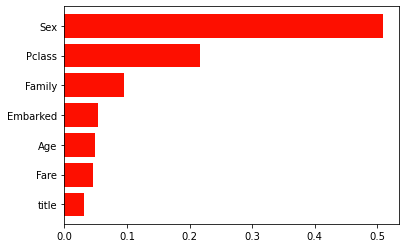

In [556]:
pd.Series(clf.feature_importances_,X_train.columns).sort_values(ascending=True).plot.barh(width=0.8,color='#FD0F00')

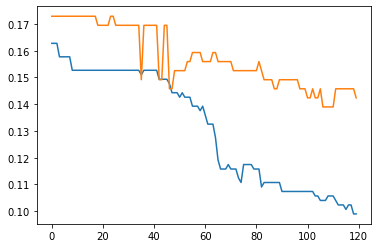

In [557]:
plt.plot(clf.evals_result()['validation_0']['error'])
plt.plot(clf.evals_result()['validation_1']['error'])

In [571]:
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import cross_val_score

In [617]:
ensemble_lin_rbf=VotingClassifier(estimators=[#('DT', DecisionTreeClassifier(random_state=0, max_depth=5)),
                                              ( 'RFC', RandomForestClassifier(random_state=None, n_estimators=100, max_depth=5)),
                                               ('XGB', xgb.XGBClassifier(verbosity=0,random_state=0, max_depth=3, n_estimators=120, reg_lambda=0.2, eta=0.1))],
                                      voting='soft').fit(X_train,y_train)
print('The accuracy for ensembled model is:',ensemble_lin_rbf.score(X_validation,y_validation))
# cross=cross_val_score(ensemble_lin_rbf,X_train,y_train, cv = 10,scoring = "accuracy")
# print('The cross validated score is',cross.mean())                                  

The accuracy for ensembled model is: 0.8745762711864407


In [544]:
clf = xgb.XGBClassifier(random_state=0, max_depth=3, n_estimators=120, reg_lambda=0.2, eta=0.1)
clf.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_validation, y_validation)], eval_metric='error', verbose=False)
# clf.predict(X_test)
clf.score(X_validation, y_validation), clf.score(X_train, y_train)

(0.8915254237288136, 0.8877665544332211)

In [600]:
from sklearn.ensemble import AdaBoostClassifier

n_estimators=list(range(100,501,100))
learn_rate=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
hyper={'n_estimators':n_estimators,'learning_rate':learn_rate}
# n_estimators=120,, eta=0.1
gd=GridSearchCV(estimator=xgb.XGBClassifier(max_depth=3,  reg_lambda=0.2),param_grid=hyper,verbose=True)

gd.fit(X_train1,y_train1)

print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8238795518207283
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=0.2, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   24.4s finished


In [601]:
# gd.best_estimator_.fit(X_train1, y_train1)
result = cross_val_score(gd.best_estimator_,X_train,y_train,cv=10,scoring='accuracy')
print('The cross validated score for XGBoost is:',result.mean())
result

The cross validated score for XGBoost is: 0.8316978776529338


array([0.78888889, 0.82022472, 0.76404494, 0.88764045, 0.8988764 ,
       0.82022472, 0.83146067, 0.7752809 , 0.88764045, 0.84269663])

In [598]:
xgboost = xgb.XGBClassifier(max_depth=3, n_estimators=120, reg_lambda=0.2, eta=0.1)
result = cross_val_score(xgboost,X_train,y_train,cv=10,scoring='accuracy')
print('The cross validated score for XGBoost is:',result.mean())
result


The cross validated score for XGBoost is: 0.8440324594257179


array([0.81111111, 0.83146067, 0.76404494, 0.8988764 , 0.91011236,
       0.84269663, 0.88764045, 0.79775281, 0.83146067, 0.86516854])

In [599]:
xgboost = AdaBoostClassifier(n_estimators=120, learning_rate=0.1)
result = cross_val_score(xgboost,X_train,y_train,cv=10,scoring='accuracy')
print('The cross validated score for XGBoost is:',result.mean())
result

The cross validated score for XGBoost is: 0.8159300873907614


array([0.82222222, 0.80898876, 0.7752809 , 0.85393258, 0.82022472,
       0.79775281, 0.80898876, 0.79775281, 0.84269663, 0.83146067])

In [616]:
df_to_csv = pd.DataFrame({'PassengerId': X_test.index, 'Survived':ensemble_lin_rbf.predict(X_test)})
df_to_csv.to_csv('titanic_result_ensemble.csv', index=False)